# Data Mining Final Project 2021 - 2022
## Authors: Beatriz Gonçalves (m20210695), Diogo Hipólito (m20210633) and Diogo Pereira (m20210657)

# 1) Introduction

The client, a Marketing Department from an an insurance company, wishes to better understand the scope of its clients, in order to better serve them and increase their ROI (Return On Investment). The group was given an ABT (Analytic Based Table), consisting of 10.290 customers and given the task of analyzing the table for evident groups of clusters, extracting the behaviour of said clusters and provide insights on how to better serve them.

The project is contained within a Github repository which can be accessed through the following link: https://github.com/beatrizctgoncalves/project_dm. This repository provides a Jupyter Notebook with all the relevant analysis and a report that summarizes the work done. Note that these two documents should be used together as they complement each other.

References: <br>
(1) https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/ <br>

## 1.1) Importing Packages

In [408]:
# Required imports for the project
#!pip install sas7bdat

from sas7bdat import SAS7BDAT
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from scipy.stats import iqr
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

# 2) Importing and Assessing Data

In [409]:
df_insurance = pd.read_sas('a2z_insurance.sas7bdat')
conn = sqlite3.connect('a2z_insurance.db')
cursor = conn.cursor()

# Build Analytical Base Table (ABT)
df_insurance.to_sql(name='file', con=conn, if_exists='replace', index=False)

In [410]:
# Dataset head
df_insurance.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [411]:
df_insurance.set_index("CustID",inplace=True)

In [412]:
# Get dimension of the dataset
df_insurance.shape

(10296, 13)

In [413]:
# Get data types and 
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10296 entries, 1.0 to 10296.0
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10279 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [414]:
# Check for duplicates
df_insurance.duplicated().sum()

3

In [415]:
#Seems like there are 3 duplicates in our data, let's remove them
df_insurance = df_insurance[df_insurance.duplicated()==False]

In [416]:
df_insurance = df_insurance.astype({"GeoLivArea": object, "Children": object})

In [447]:
df_insurance["EducDeg"] = df_insurance["EducDeg"].astype("category").cat.rename_categories({b'1 - Basic':'1',b'2 - High School':'2',b'3 - BSc/MSc':'3',b'4 - PhD':'4'}).cat.reorder_categories(['1','2','3','4'])

In [418]:
#First divide the variables into metric and non-metric
non_metric_features = ["EducDeg","GeoLivArea","Children"]
metric_features = df_insurance.columns.difference(non_metric_features)

print("Non metric features: ")
print(non_metric_features)

print("Metric features: ")
print(metric_features)

Non metric features: 
['EducDeg', 'GeoLivArea', 'Children']
Metric features: 
Index(['BirthYear', 'ClaimsRate', 'CustMonVal', 'FirstPolYear', 'MonthSal',
       'PremHealth', 'PremHousehold', 'PremLife', 'PremMotor', 'PremWork'],
      dtype='object')


In [419]:
desc_num = df_insurance[metric_features].describe().T
missing = df_insurance.isnull().sum(axis=0)
desc_num["missing values"] = missing

desc_num

,count,mean,std,min,25%,50%,75%,max,missing values
BirthYear,10276.0,1968.006909,19.710742,1028.00,1953.00,1968.00,1983.00,2001.00,17
ClaimsRate,10293.0,0.742728,2.917385,0.00,0.39,0.72,0.98,256.20,0
CustMonVal,10293.0,177.929963,1946.091554,-165680.42,-9.44,187.03,399.86,11875.89,0
FirstPolYear,10263.0,1991.064893,511.342617,1974.00,1980.00,1986.00,1992.00,53784.00,30
MonthSal,10257.0,2506.618699,1157.518390,333.00,1706.00,2502.00,3290.00,55215.00,36
PremHealth,10250.0,171.553183,296.444399,-2.11,111.80,162.81,219.04,28272.00,43
PremHousehold,10293.0,210.419863,352.635041,-75.00,49.45,132.80,290.05,25048.80,0
PremLife,10189.0,41.848724,47.484264,-7.00,9.89,25.56,57.79,398.30,104
PremMotor,10259.0,300.501550,211.937740,-4.11,190.59,298.61,408.30,11604.42,34
PremWork,10207.0,41.283712,51.519022,-12.00,10.67,25.67,56.79,1988.70,86


Problematic values:
- BirthYear: min = 1028. That is impossible, that person would have to be almost 1000 years old
- FirstPolYear: max = 53784. Impossible, there can't be data from the future
- Every other variable: Looks like there are a lot of outliers. The difference between the 75th percentile and the max is signficant, so does between the 25th percentile and the min.

Missing values: We will have to decide later on how to deal with the missing values, the PremLife variable specifically has a lot of missing values (104).

In [420]:
desc_cat= df_insurance[non_metric_features].describe().T
mode = df_insurance[non_metric_features].mode().T
desc_cat["mode"] = mode
desc_cat["missing values"] = missing
desc_cat

,count,unique,top,freq,mode,missing values
EducDeg,10276,4,b'3 - BSc/MSc',4799,b'3 - BSc/MSc',17
GeoLivArea,10292.0,4.0,4.0,4142.0,4.0,1
Children,10272.0,2.0,1.0,7260.0,1.0,21


There are some missing values, but nothing worrying

# 3) Data Cleaning

## 3.1) Verify Coherence
This section's goal is to verify if all the data makes logical sense.
The logical rules that we want to clarify are:
* Are there client whose first policy predates their birth year?
* Are there minors with children?
* Are there minors with car insurance? 
* Are there customers older than 120 or not born yet?
<br/>
<br/>
As can be seen in the code below we test this conditions.

In [421]:
policy_before_birth = future_dates = df_insurance.loc[df_insurance["FirstPolYear"] < df_insurance["BirthYear"]]
print(f"Number of first policies before birth: {policy_before_birth.shape[0]}")

minors_with_children = df_insurance.loc[(df_insurance["BirthYear"] >= 1999) & (df_insurance["Children"]==1)]
print(f"Number of minors with children: {minors_with_children.shape[0]}")

minors_with_cars = df_insurance.loc[(df_insurance["BirthYear"] >= 1999) & (df_insurance["PremWork"]>0)]
print(f"Number of minors with cars: {minors_with_cars.shape[0]}")

invalid_birth = df_insurance.loc[(df_insurance["BirthYear"] > 2016) | (df_insurance["BirthYear"] < 1896)]
print(f"Number of invalid birth years: {invalid_birth.shape[0]}")

invalid_pol = df_insurance.loc[(df_insurance["FirstPolYear"] > 2016) | (df_insurance["FirstPolYear"] < 1896)]
print(f"Number of invalid first policy years: {invalid_pol.shape[0]}")

Number of first policies before birth: 1997
Number of minors with children: 87
Number of minors with cars: 114
Number of invalid birth years: 1
Number of invalid first policy years: 1


All sanity checks of the the birth year variable have failed significantly. The amount of erros in this variable is too significant for us to use it in the future, therefore we will drop the column "BirthYear".

In [422]:
df_insurance.drop(columns=["BirthYear"],inplace=True)
metric_features = metric_features.drop("BirthYear")

## 3.1) Outliers

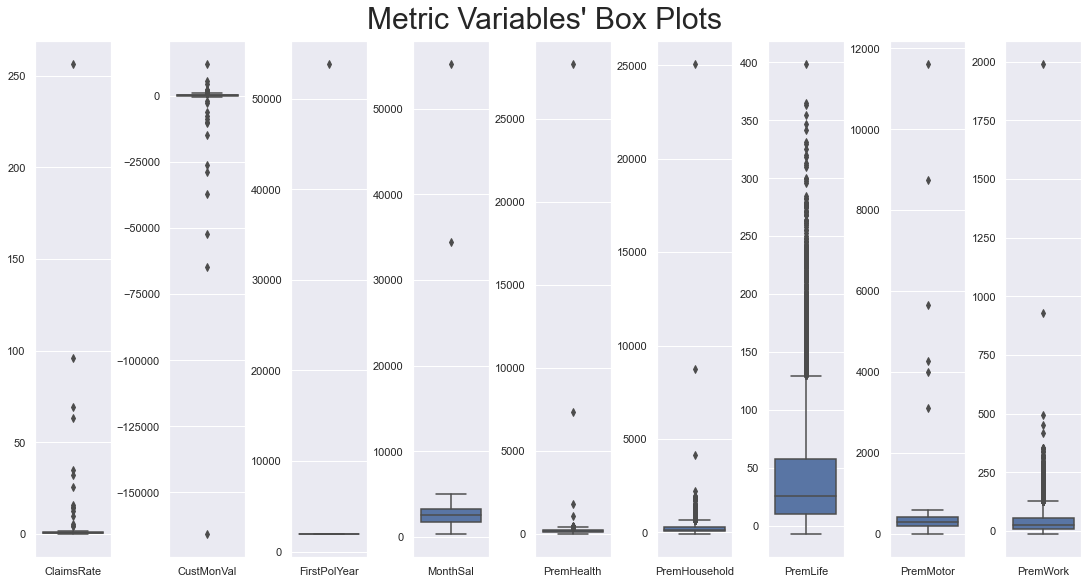

In [423]:
def boxplot(df_metric_features):
    # All Metric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure
    # Prepare dataframe layout:
    data = df_metric_features.melt()
    plot_features = metric_features
    #Prepare figure layout:
    fig, axes = plt.subplots(1, len(plot_features), figsize=(15, 8), constrained_layout=True)

    # Plot data
    # Draw the box plots:
    for i in zip(axes, plot_features):
        sns.boxplot(x="variable", y="value", data=data.loc[data["variable"]==i[1]], ax=i[0])
        i[0].set_xlabel("")
        i[0].set_ylabel("")

    # Layout
    # Add a centered title to the figure:
    title = "Metric Variables' Box Plots"
    plt.suptitle(title, fontsize=30)

    plt.show()

boxplot(df_insurance[metric_features])

Manual outlier removal

In [424]:
# First we remove unreasonable values
def remove_outliers(df):
    filters = (
        (df["ClaimsRate"] > 50)
        |
        (df["CustMonVal"] < -25000)
        |
        (df["FirstPolYear"] > 2017)
        |
        (df["MonthSal"] > 30000)
        |
        (df["PremHealth"] > 5000)
        |
        (df["PremHousehold"] > 4000)
        |
        (df["PremMotor"] > 2000)
        |
        (df["PremWork"] > 750)
        )
    outliers = df[filters]
    return df.drop(outliers.index),outliers

df_manual,outliers = remove_outliers(df_insurance)
print("Percentage of data kept after removing outliers: "
      + str(round(df_manual.shape[0] / df_insurance.shape[0], 4)))


Percentage of data kept after removing outliers: 0.998


In [425]:
df_insurance = df_manual.copy()

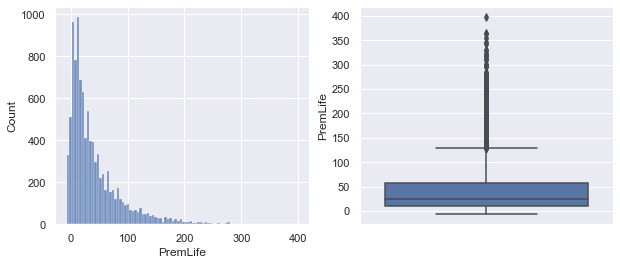

In [426]:
def check_outliers(df,variable):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    sns.histplot(x=variable,data=df,ax=ax1)
    sns.boxplot(y=variable,data=df,ax=ax2)
    
check_outliers(df_manual,"PremLife")

<AxesSubplot:ylabel='ClaimsRate'>

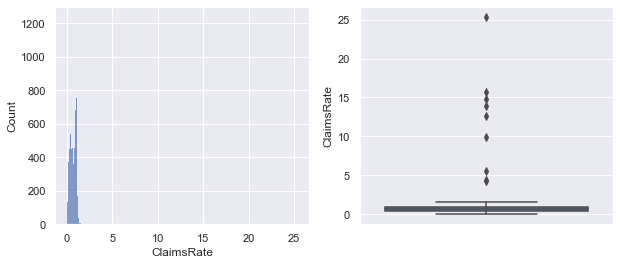

In [427]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(x="ClaimsRate",data=df_insurance,ax=ax1)
sns.boxplot(y="ClaimsRate",data=df_insurance,ax=ax2)

## 3.2) Missing values

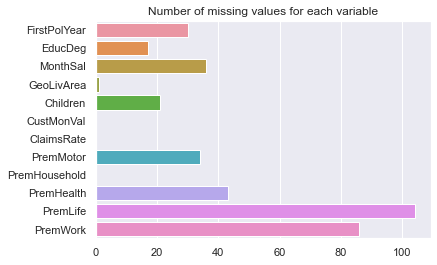

In [428]:
#Let's see how many values are missing for each variable
def count_missing(df):
    missing = df.isna().sum()
    sns.barplot(x=missing.values,y=missing.index)
    plt.title("Number of missing values for each variable")

    plt.show()
    
count_missing(df_insurance)

Most of the missing values are on the "PremLife" and "PremWork" variables. <br>
Do the missing values in the premium columns represent zeros? <br>
We need to see how many zero values are on each of the premium variables. <br>

In [429]:
# Set a variable with the columns related to premiums for future use
premiums = ["PremMotor","PremHealth","PremLife","PremWork","PremHousehold"]

The column PremHousehold has a total amount of 60 zero values


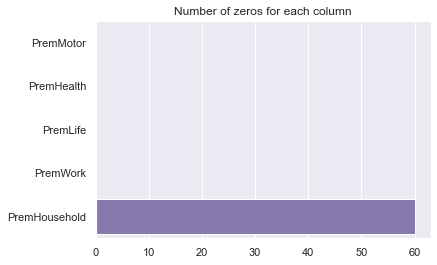

In [430]:
# For each premium column, we will count the occurences of zero values 
names = []
zeros = []
for i in df_insurance[premiums]:
    name = i 
    total = sum(df_insurance[i] == 0)
    
    if(total > 0):
        print(f"The column {i} has a total amount of {total} zero values")
    
    names.append(name)
    zeros.append(total)
    
sns.barplot(x=zeros,y=names)
plt.title("Number of zeros for each column")
plt.show()

The only Premium variable with zero values is PremHousehold, with 60 total zero values. <br>
There are two options to consider: <br>
- Zeros represent missing values - if so, why are they only present in "PremiumHousehold"?
- Missing values mean zero - why is this not applied in "PremiumHousehold" then?

We also need to consider the fact that we have already encountered errors previously, with the BirthYear variable, so we know the integrity of the dataset is dubious. <br>

Given all these factors, we will not replace the missing values with 0, instead we will use an independetn approach, impute the missing values with the mean of its neighbors uisng KNNImputer.

In [431]:
knn_imputer = KNNImputer()
df_num_imputed = pd.DataFrame(knn_imputer.fit_transform(df_insurance[metric_features]),columns=df_insurance[metric_features].columns)

For categorical features, we cannot use the mean as the imputer metric. So we will use Simple Imputer for categorical variables, which will replace missing values with the mode of each variable.

In [432]:
simple_imputer = SimpleImputer(strategy="most_frequent")
df_cat_imputed = pd.DataFrame(simple_imputer.fit_transform(df_insurance[non_metric_features]), columns = df_insurance[non_metric_features].columns)

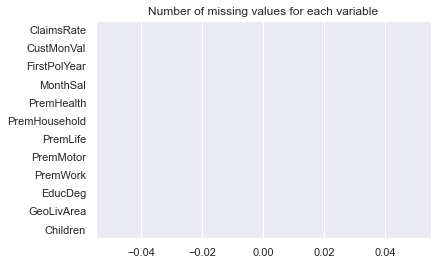

In [433]:
#After imputing the numeric and categorical features, we need to merge both dataframes.
df_imputed = df_num_imputed.join(df_cat_imputed)
count_missing(df_imputed)

Looks like the imputers were successful, there are no missing values remaining in our dataframe.

In [434]:
#Set the dataframe without missing values as the main dataframe
df_insurance = df_imputed.copy()

## Non metric variables

Since we have only 3 categorical variables, we can plot their significance using just one plot, composed by multiple suplots. We will use pointplots, which are typically used for focusing comparisons between different levels of one or more categorical variables.

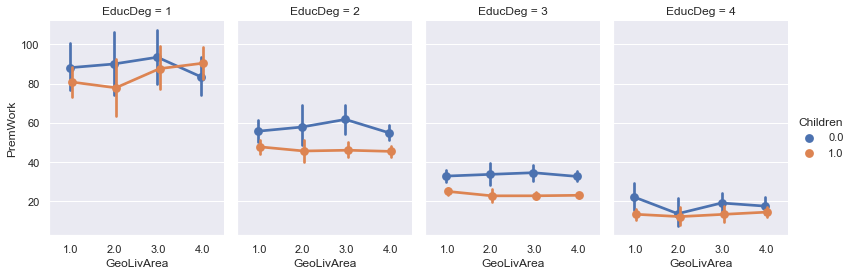

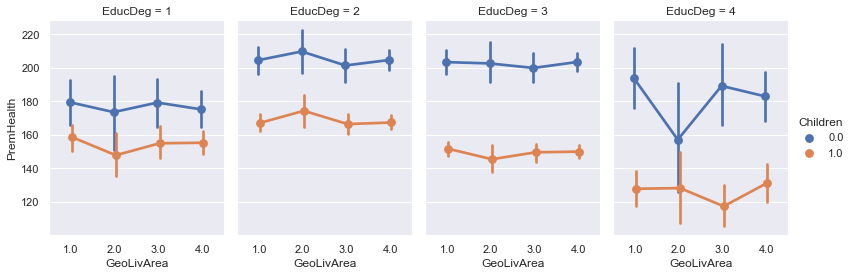

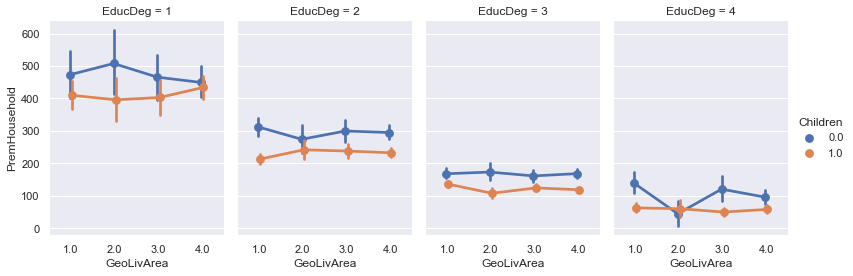

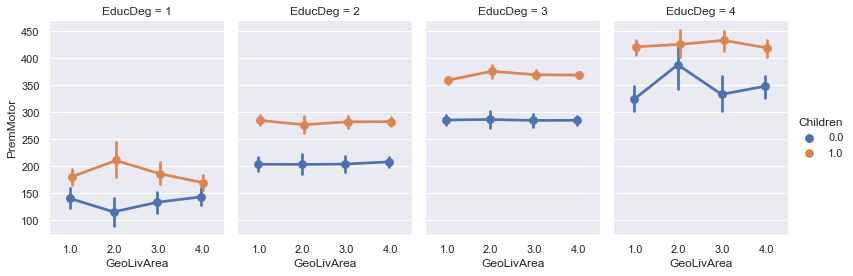

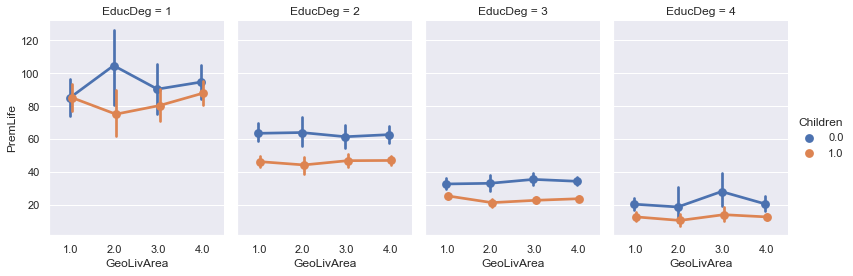

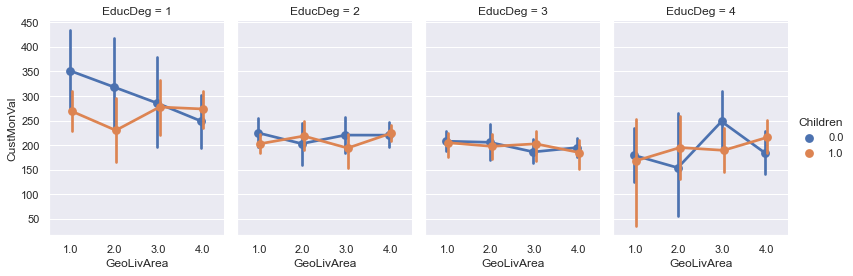

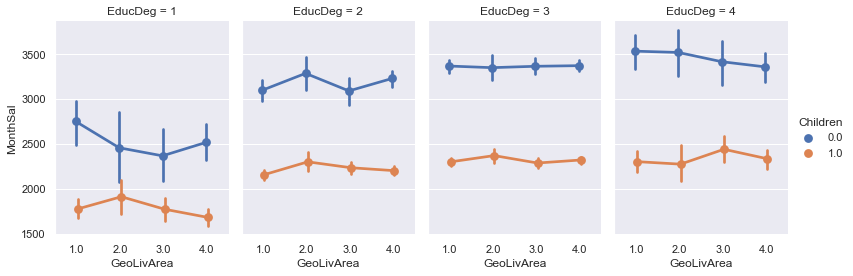

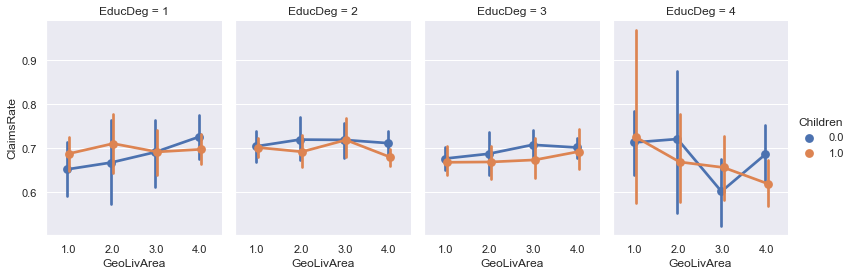

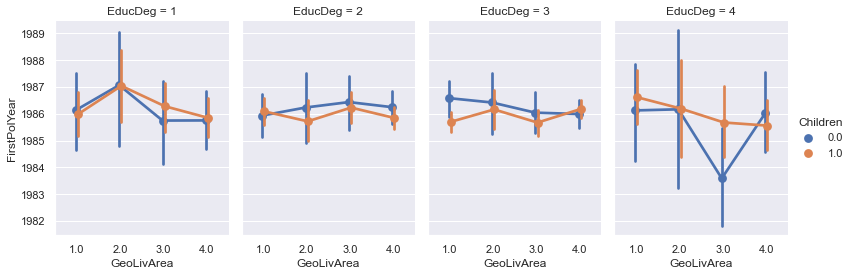

In [448]:
variables = ["PremWork","PremHealth","PremHousehold","PremMotor","PremLife",
             "CustMonVal","MonthSal","ClaimsRate","FirstPolYear"]
for i in variables:
    g = sns.catplot(x="GeoLivArea", y=i,

                hue="Children", col="EducDeg",

                data=df_insurance, kind="point",

                dodge=True,

                height=4, aspect=.7);

plt.show()

Comments:
- Children: 
 - Clear effect on salary, children = less salary.
 - Minor but still noticeable effect on all of the different premiums, children = more PremMotor and less of everything else.
 
- EducDeg:
 - Salary - More education = more salary. Clear impact on salary, particularly between basic education and all other kinds of education.
 - Noticeable difference in premium costs: More education relates to more PremMotor and less PremLife,PremWork. 
 
- GeoLivArea:
 - It doesn't look like the customer's area has any significant impact on any of the metric variables. 

## Feature engineering

#1 - Converting monthly salary to yearly salary. Since the premium costs are represented as yearly, it is better to use yearly instead of monthly salary for consistency sake. YearlySal = MonthSal * 12. <br>
#2 - Converting FirstPolYear to ClientYears. Measures the number of years since the first policy. It makes the data simpler and easier to analyze. ClientYears = 2016 - FirstPolYear. <br>
#3 - TotalPremiums. Sum of all premiums categories
#4 - Canceled. Will represent which customers have canceled an insurance contract. 